# Single stock performance tracking

In [1]:
import pandas as pd
from dataclasses import dataclass
# from tracking_2 import *
import logging

# Configure logging to show INFO level messages
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [2]:
from tracking import MarketVisualize
from dataclasses import dataclass,field
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
@dataclass
class Tracking2(MarketVisualize):
    weight: pd.DataFrame = field(default_factory=pd.DataFrame)
    def __str__(self):
        print("Tracking by Kevin")
    def single_stock_summary(self, year_build, rank,return_col,keep_period=1):
        df= self.stocks_data.copy()
        stock_weight = self.weight.loc[year_build,rank].copy()
        df = df[(df['ticker'].isin(stock_weight.index))
                & (df['time'].dt.year >= year_build)
                & (df['time'].dt.year <= year_build+keep_period)]
        df.sort_values(['ticker','time'],inplace=True)
        logging.info(f"yearbuild: {year_build}")
        logging.info(f"Min time {df['time'].min()}")
        logging.info(f"Max time {df['time'].max()}")
        df['cumulative_return'] = (1 + df['return']).groupby(df['ticker']).cumprod()-1

        df['cumulative_log_return'] = (df['log_return']).groupby(df['ticker']).cumsum()
        summary_df = pd.DataFrame({
            'mean_return': df.groupby('ticker')[return_col].sum(),
            'tail_return': df.groupby('ticker')[return_col].tail(1).values,
            'close_begin': df.groupby('ticker')['close'].head(1).values,
            'close_end': df.groupby('ticker')['close'].tail(1).values
        })
        summary_df['year_train'],summary_df['rank']=year_build,rank
        return summary_df.reset_index()
    def all_data_summary(self,return_col,keep_period):
        max_year=self.stocks_data['time'].dt.year.max()-keep_period
        available_ranks = self.weight.sort_index().index.tolist()
        all_combinations = [(single[0], single[1]) for single in available_ranks if single[0]<=max_year]
        from joblib import Parallel,delayed

        # Try parallel processing, fall back to sequential if error occurs
        try:
            results = Parallel(n_jobs=-10)(
                delayed(self.single_stock_summary)(single[0], single[1], return_col, keep_period,)
                for single in all_combinations
            )
        except (ZeroDivisionError, Exception) as e:
            logging.warning(f"Parallel processing failed, falling back to sequential processing: {e}")
            results = []
            for single in all_combinations:
                result = self.single_port_summary(single[0], single[1],return_col,  keep_period)
                results.append(result)
        return pd.concat(results)
import seaborn as sns
def plot_year_stock(df, year):
    df = df[df['year_train'] == year].copy()
    df.sort_values(['ticker','rank'], inplace=True)
    plot_attributes = ['mean_return','tail_return','close_begin','close_end']
    plt.figure(figsize=(16, 8))
    n_plots = len(plot_attributes)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    for i, attr in enumerate(plot_attributes):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        sns.lineplot(data=df, x='rank', y=attr, hue='ticker', marker='o', ax=ax)
        ax.set_title(f'{attr} by Rank for Year {year}')
        ax.set_xlabel('Rank')
        ax.set_ylabel(attr)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()
def plot_rank_stock(df, rank):
    df = df[df['rank'] == rank].copy()
    df.sort_values(['ticker','year_train'], inplace=True)
    plot_attributes = ['mean_return','tail_return','close_begin','close_end']
    plt.figure(figsize=(16, 8))
    n_plots = len(plot_attributes)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    for i, attr in enumerate(plot_attributes):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        sns.lineplot(data=df, x='year_train', y=attr, hue='ticker', marker='o', ax=ax)
        ax.set_title(f'{attr} by Year for Rank {rank}')
        ax.set_xlabel('Year')
        ax.set_ylabel(attr)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

In [3]:
weight_vn30 = pd.read_parquet("./data/weight_vn30.parquet")
tracking_instance = Tracking2(
    path="./data/stock/",
    path_dictionary="./stock_dictionary.json",
    remove_current_year=True,
    weight=weight_vn30,
    risk_free_rate=0.05,
)

out=tracking_instance.all_data_summary(return_col='return',keep_period=2)
out.head(1)

2025-01-19 14:13:21,477 - INFO - Max time in merged data: 2025-01-17 00:00:00
2025-01-19 14:13:21,701 - INFO - Summary of tickers by exchange: {'DELISTED': 611, 'HNX': 313, 'HSX': 500, 'UPCOM': 884}


,ticker,mean_return,tail_return,close_begin,close_end,year_train,rank
0,ACB,0.33021,0.016129,2.9,3.78,2013,0


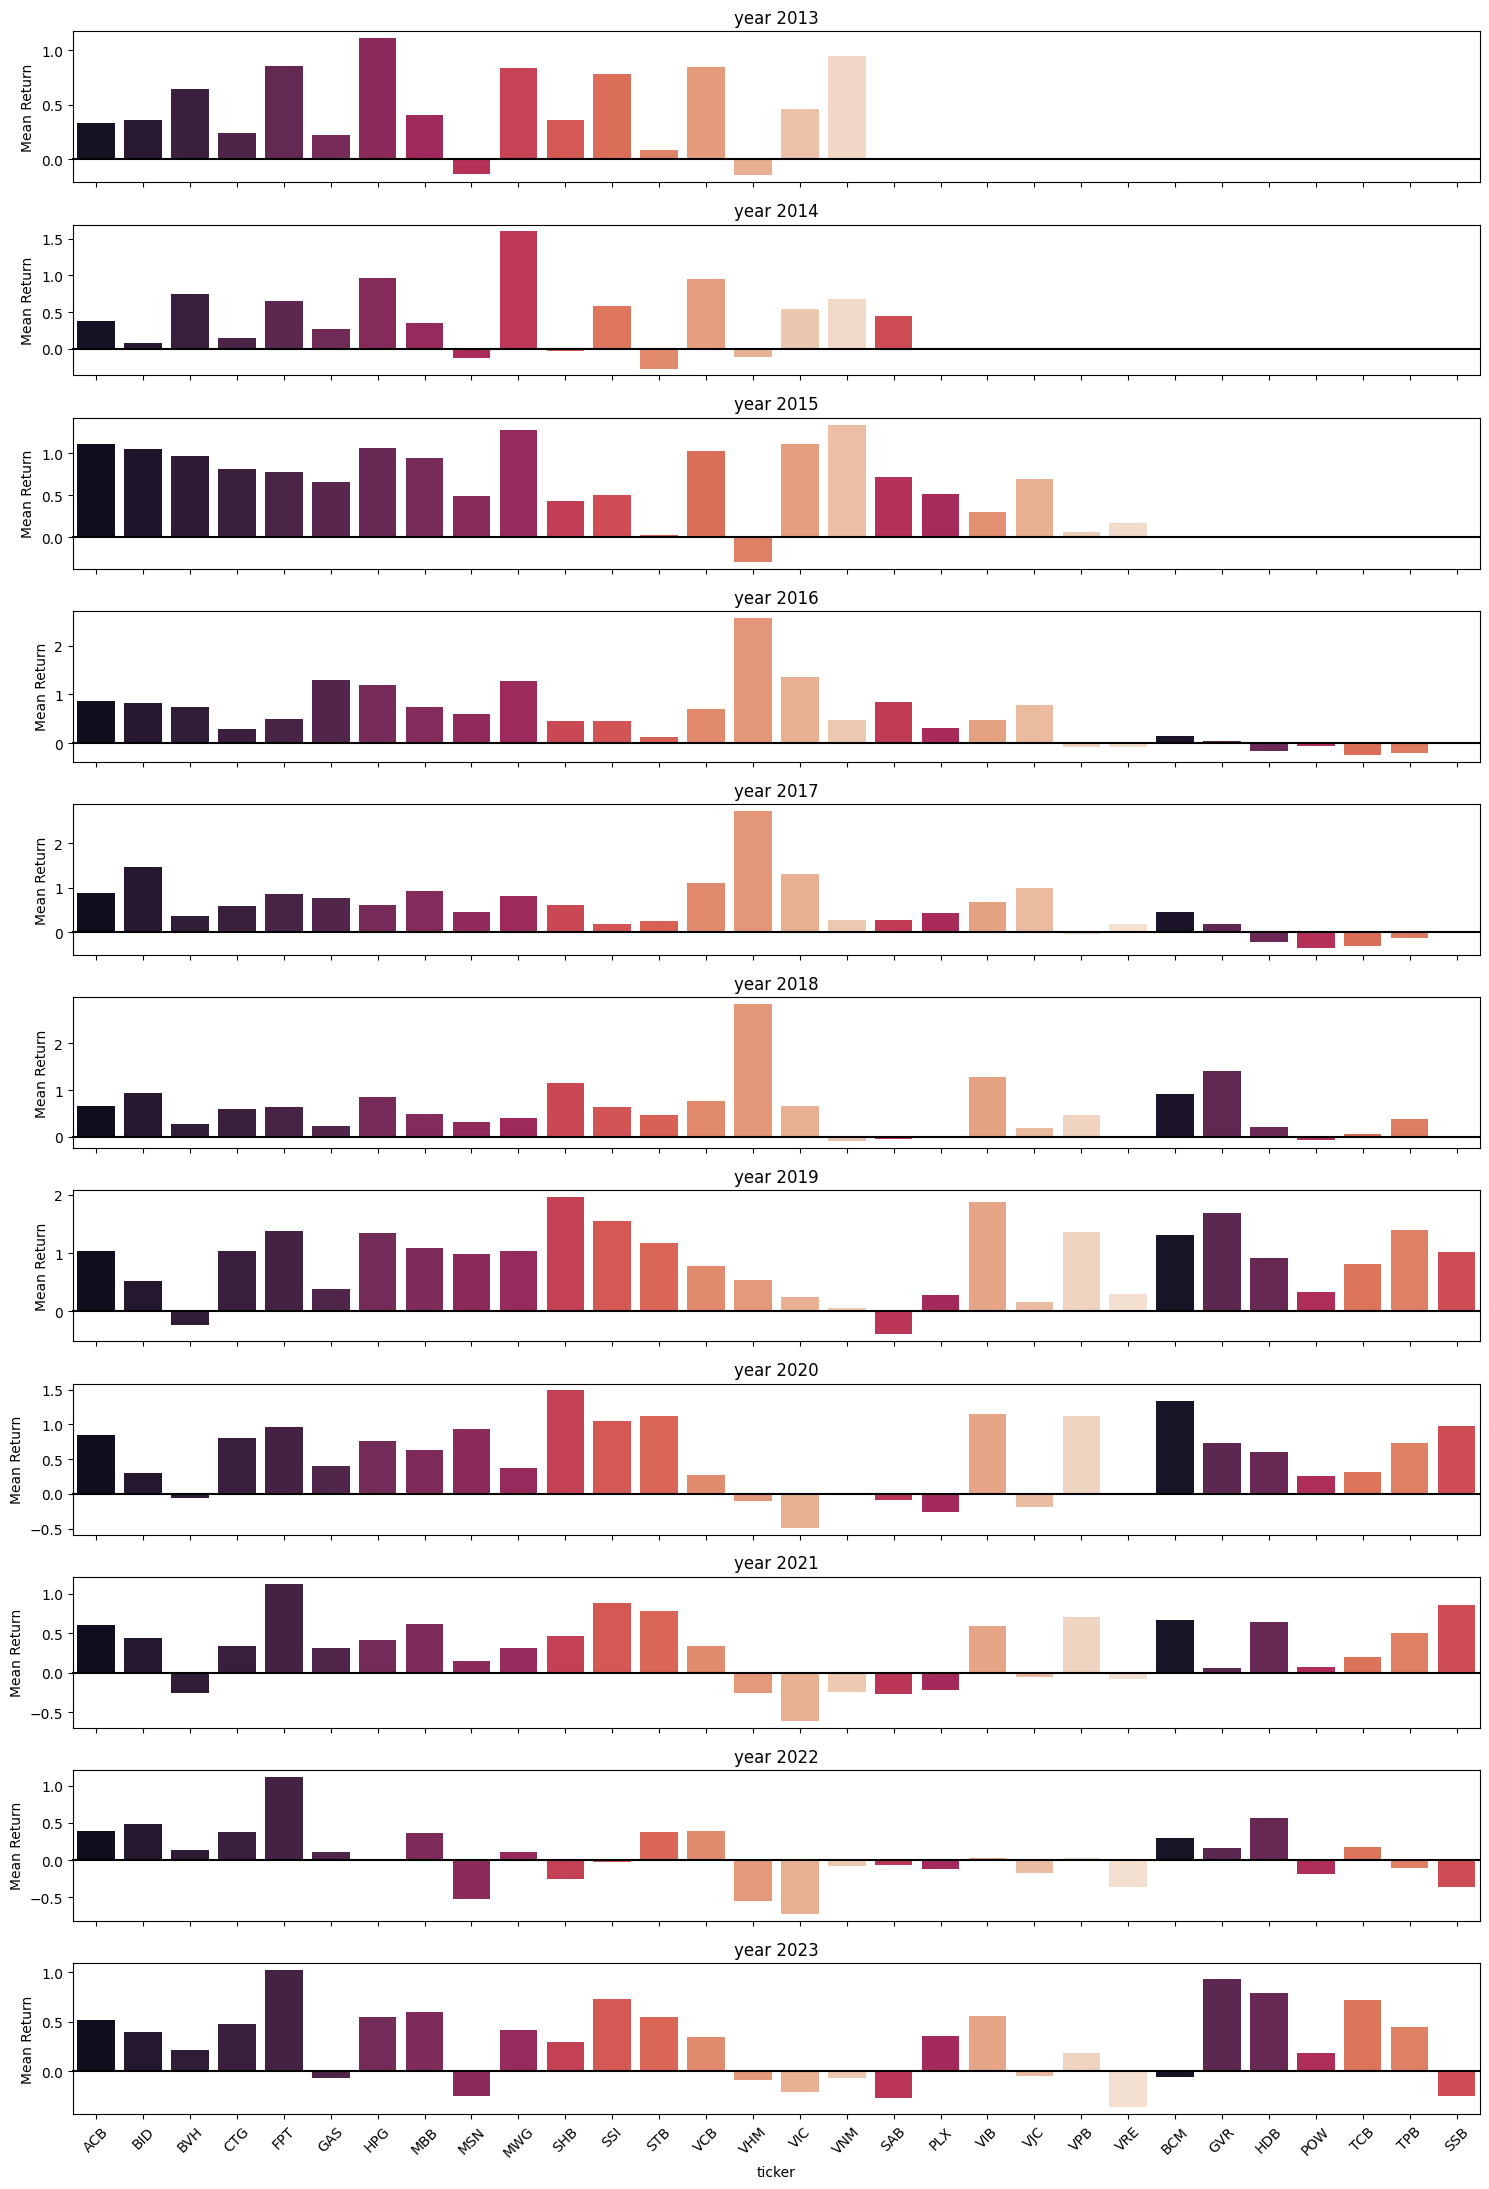

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
n_ranks = out['year_train'].nunique()
f, axes = plt.subplots(n_ranks, 1, figsize=(15, n_ranks*2), sharex=True)
for j,i in enumerate(out['year_train'].unique()):
    df=out[(out['year_train']==i)].drop_duplicates()
    sns.barplot(data=df,x='ticker', y='mean_return', hue='ticker', palette="rocket", ax=axes[j])
    axes[j].axhline(0, color="k", clip_on=False)
    axes[j].set_title(f'year {i}')
    axes[j].set_ylabel('Mean Return')
    axes[j].tick_params(axis='x', rotation=45)
    if hasattr(axes[j], 'legend_') and axes[j].legend_ is not None:
        axes[j].legend_.remove()
    # plt.suptitle(f'Year {i}', y=1.02, fontsize=16)
    plt.tight_layout()
plt.show()